In [76]:
%load_ext autoreload
%autoreload 2

from scipy.stats import binom, beta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from contamination_estimation import VariantPosition, estimate_contamination, CONTAMINATION_RANGE
# https://github.com/liguowang/dcon/blob/master/lib/DconModule/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
VariantPosition(100,90,"HOM").log_contam_probability(0.1)

-2.02597397686619

In [78]:
def plot_result(vp, dist, sorted_likelihoods):
    fig = plt.figure(figsize=(10,4))
    ax=fig.add_subplot(121)
    ys = [v.alt_depth/v.total_depth for v in vp]
    sns.distplot(ys, ax=ax, hist=False)
 
    ax=fig.add_subplot(122)
    ax.plot(list(dist.keys()), list(dist.values()))
    ax.vlines(x = sorted_likelihoods[-1][0], ymin=-1000, ymax=0, color='red')
    fig.tight_layout()
    sns.despine()

Simulating: 0.0; Estimated: 0.006


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.05; Estimated: 0.053


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.1; Estimated: 0.107


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.15000000000000002; Estimated: 0.152


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.2; Estimated: 0.20700000000000002


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.25; Estimated: 0.254


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.30000000000000004; Estimated: 0.304


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.35000000000000003; Estimated: 0.353


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.4; Estimated: 0.399


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.45; Estimated: 0.399


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


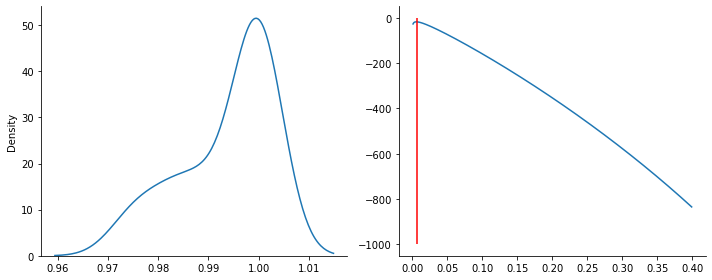

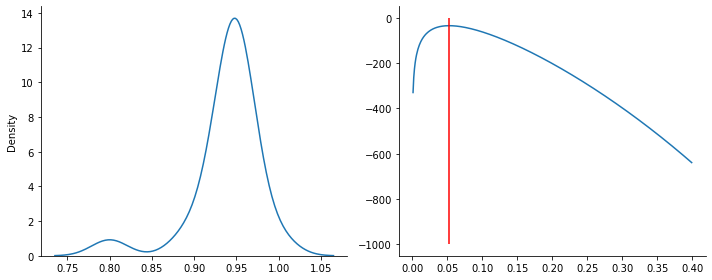

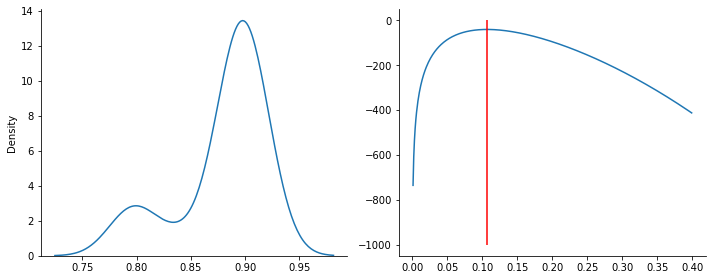

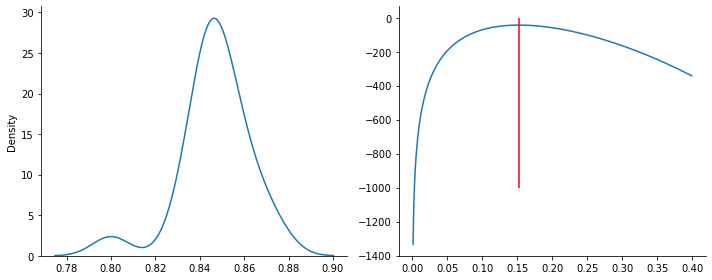

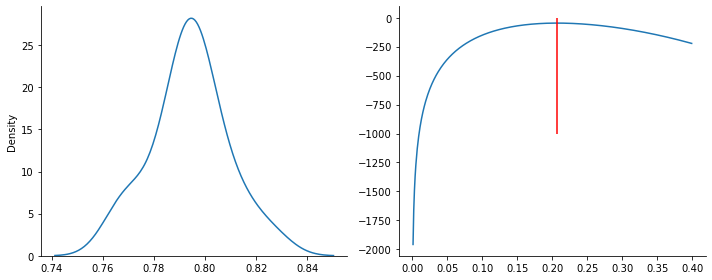

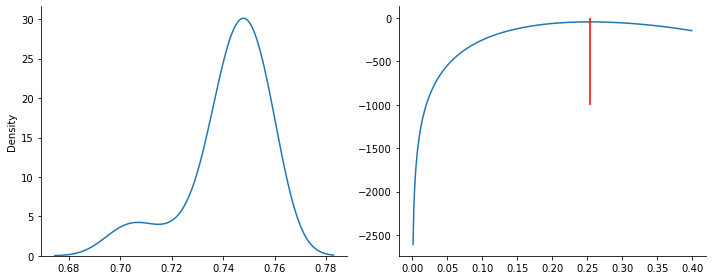

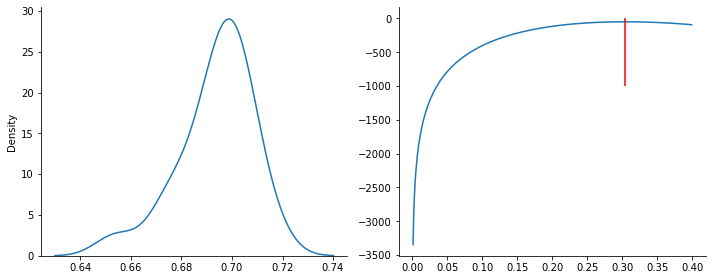

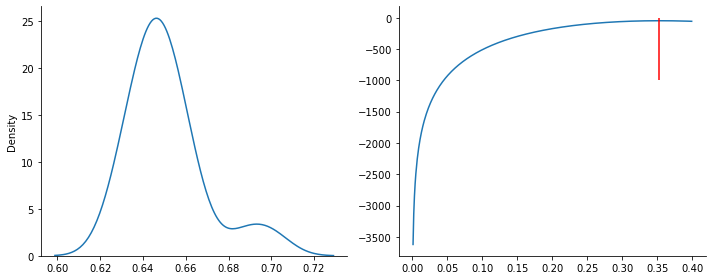

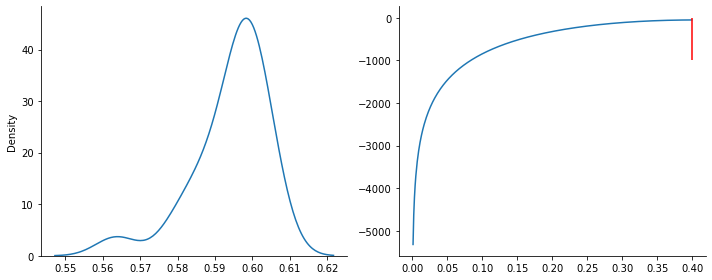

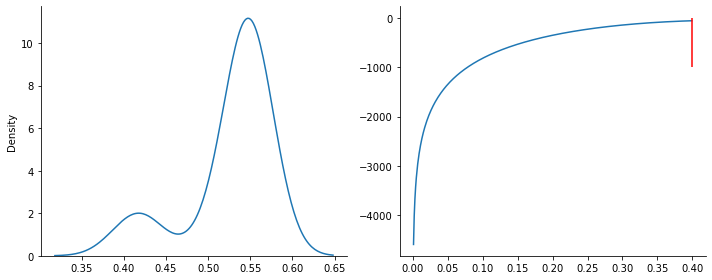

In [79]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data HOM
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        alt_depth = total_depth - max(0, total_depth - np.random.normal(loc=total_depth * (1-simulated_contam) ))
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HOM')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    plot_result(vp, dist, sorted_likelihoods)
    

Simulating: 0.0; Estimated: 0.015


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.05; Estimated: 0.063


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.1; Estimated: 0.107


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.15000000000000002; Estimated: 0.169


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.2; Estimated: 0.394


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.25; Estimated: 0.374


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.30000000000000004; Estimated: 0.34900000000000003


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.35000000000000003; Estimated: 0.365


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.4; Estimated: 0.299


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.45; Estimated: 0.27


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


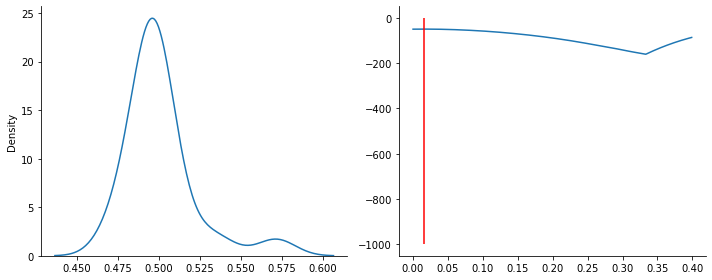

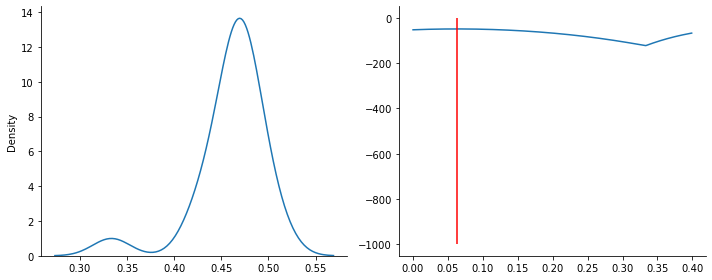

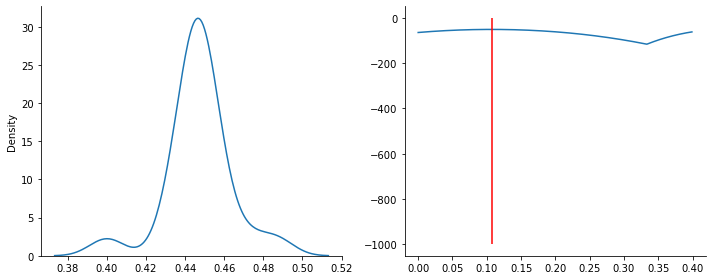

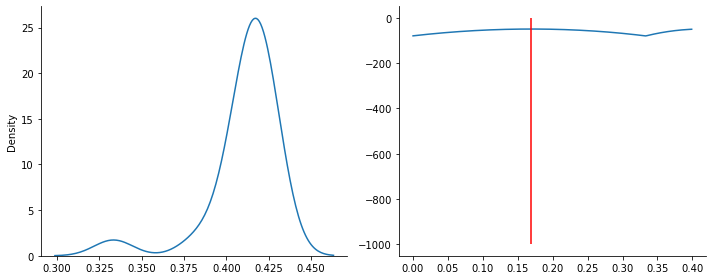

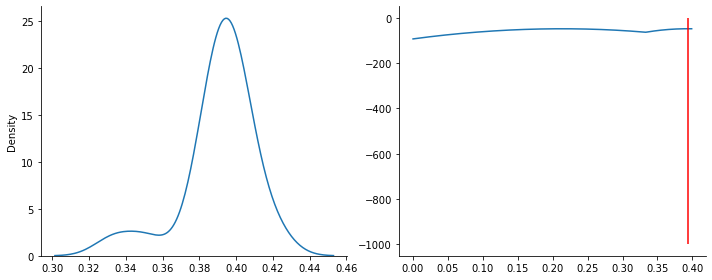

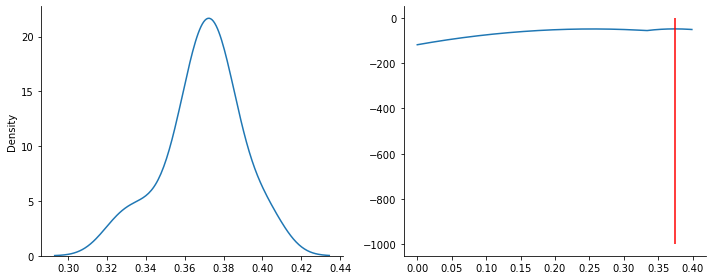

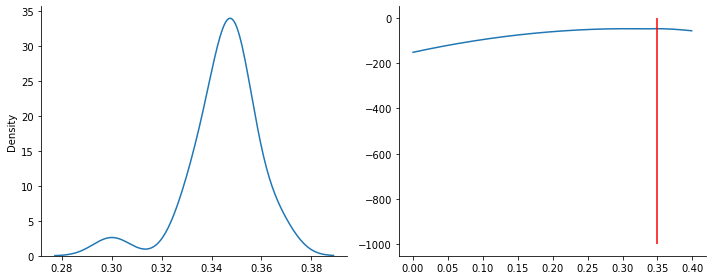

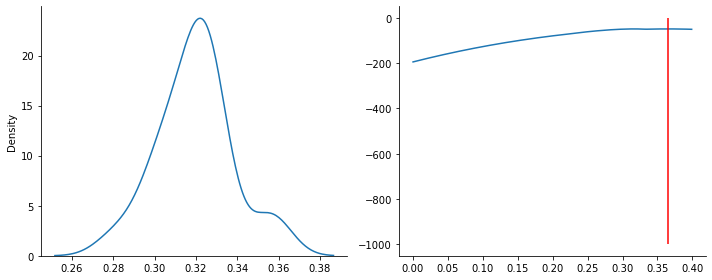

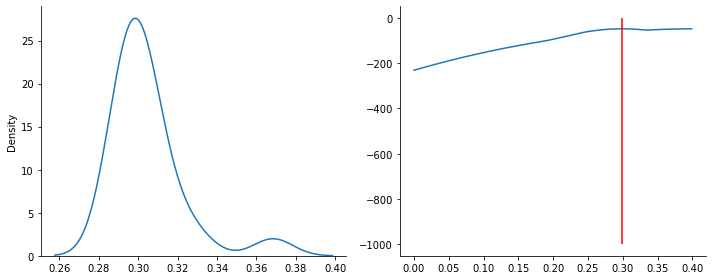

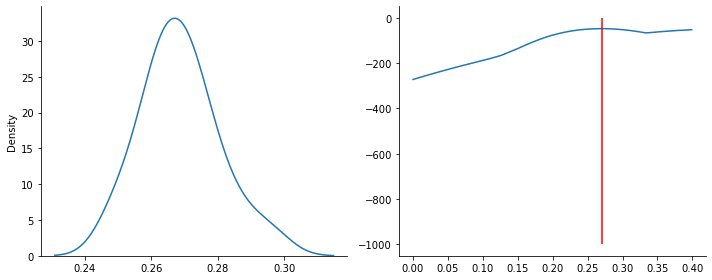

In [51]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data HET
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        allele1_fraction = total_depth * 0.5
        alt_depth = total_depth / 2 
        alt_depth = np.random.normal(loc=alt_depth * (1-simulated_contam) )

        
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HET')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    
    plot_result(vp, dist, sorted_likelihoods)

In [63]:
import pysam

variants = pysam.VariantFile('data/test.vcf')
for variant in variants:
    print(
        f"MagicMock(filter={list(variant.filter)},alleles={variant.alleles},"
        "samples=[{'DP':%i, 'AD': %s, 'GT': %s}])," %(variant.samples[0]["DP"], variant.samples[0]["AD"], variant.samples[0]["GT"])
    )

MagicMock(filter=['PASS'],alleles=('CT', 'C'),samples=[{'DP':1152, 'AD': (460, 552), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('CTCCTCTCCTTCCTCT', 'C'),samples=[{'DP':1122, 'AD': (647, 469), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('CTCTCCT', 'C'),samples=[{'DP':1044, 'AD': (604, 437), 'GT': (0, 1)}]),
MagicMock(filter=['RefCall'],alleles=('C', 'T'),samples=[{'DP':1043, 'AD': (600, 442), 'GT': (None, None)}]),
MagicMock(filter=['PASS'],alleles=('T', 'C'),samples=[{'DP':978, 'AD': (534, 441), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('T', 'C'),samples=[{'DP':1038, 'AD': (536, 493), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('C', 'A'),samples=[{'DP':1051, 'AD': (550, 487), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('T', 'C'),samples=[{'DP':1053, 'AD': (547, 476), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('T', 'A'),samples=[{'DP':1054, 'AD': (563, 483), 'GT': (0, 1)}]),
MagicMock(filter=['PASS'],alleles=('CTT', 'C'),samples=[{'DP'

In [64]:
from contamination_estimation import estimate_vcf_contamination_level

In [65]:
estimate_vcf_contamination_level('data/test.vcf')

INFO:root:Processing 7 variants


0.08600000000000001

In [66]:
from unittest.mock import MagicMock, call, patch

In [73]:
MOCK_VCF_RECORDS = [
    MagicMock(filter=["PASS"], alleles=("CT", "C"), samples=[{"DP": 1152, "AD": (460, 552), "GT": (0, 1)}]),
    MagicMock(
        filter=["PASS"], alleles=("CTCCTCTCCTTCCTCT", "C"), samples=[{"DP": 1122, "AD": (647, 469), "GT": (0, 1)}]
    ),
    MagicMock(filter=["PASS"], alleles=("CTCTCCT", "C"), samples=[{"DP": 1044, "AD": (604, 437), "GT": (0, 1)}]),
    MagicMock(filter=["RefCall"], alleles=("C", "T"), samples=[{"DP": 1043, "AD": (600, 442), "GT": (None, None)}]),
    MagicMock(filter=["PASS"], alleles=("T", "C"), samples=[{"DP": 978, "AD": (534, 441), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("T", "C"), samples=[{"DP": 1038, "AD": (536, 493), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("C", "A"), samples=[{"DP": 1051, "AD": (550, 487), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("T", "C"), samples=[{"DP": 1053, "AD": (547, 476), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("T", "A"), samples=[{"DP": 1054, "AD": (563, 483), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("CTT", "C"), samples=[{"DP": 1065, "AD": (577, 445), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("CT", "C"), samples=[{"DP": 1058, "AD": (597, 459), "GT": (0, 1)}]),
    MagicMock(filter=["PASS"], alleles=("C", "T"), samples=[{"DP": 1053, "AD": (569, 466), "GT": (0, 1)}]),
    MagicMock(filter=["RefCall"], alleles=("T", "C"), samples=[{"DP": 1044, "AD": (554, 466), "GT": (None, None)}]),
    MagicMock(filter=["PASS"], alleles=("TTCC", "T"), samples=[{"DP": 1068, "AD": (600, 453), "GT": (0, 1)}]),
    MagicMock(
        filter=["PASS"],
        alleles=("C", "CCCTCCCCTTCTCCTTCCTCCCCTTCTT"),
        samples=[{"DP": 1100, "AD": (679, 374), "GT": (0, 1)}],
    ),
    MagicMock(filter=["PASS"], alleles=("C", "T"), samples=[{"DP": 1131, "AD": (583, 517), "GT": (0, 1)}]),
]

temp_vcf =   "mypy.ini"
with patch("pysam.VariantFile") as mock_variants:
    mock_variants.__enter__.return_value = MagicMock(__iter__=MOCK_VCF_RECORDS)
    estimate_vcf_contamination_level(temp_vcf, snv_only=True)

INFO:root:Processing 0 variants


<MagicMock name='VariantFile' id='4838965840'>

In [81]:
VariantPosition(1,100, genotype="HOM")

ValidationError: 1 validation error for VariantPosition
alt_depth
  total_depth must be > alt_depth (type=value_error)